<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/WhatCanBeForecasted_python_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install EntropyHub
from EntropyHub import ApEn
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

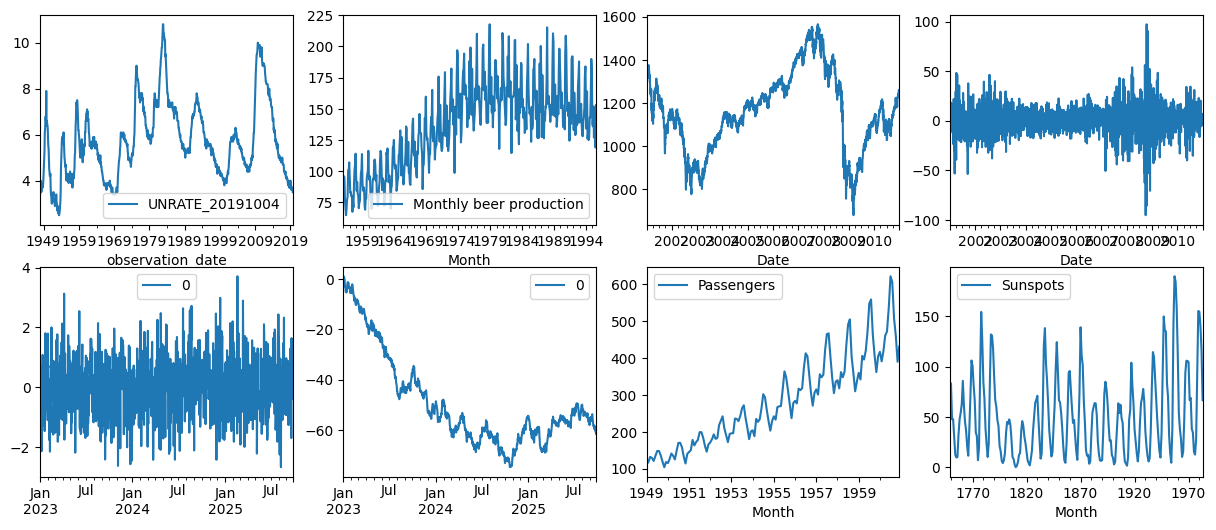

In [3]:

df_uschange = pd.read_csv('https://raw.githubusercontent.com/robjhyndman/fpp3package/master/data-raw/US_change/uschange_fpp3_Monthly.txt', delimiter='\t', index_col='observation_date')
df_uschange.index = pd.DatetimeIndex(df_uschange.index)

df_beer = pd.read_csv('https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv', index_col='Month', parse_dates=True)
df_beer.index = pd.DatetimeIndex(df_beer.index)

df_goog = pd.read_csv('https://raw.githubusercontent.com/bharatpurohit97/StockPrediction/master/ReinforcementLearning-YahooFinance/data/%5EGSPC.csv', index_col='Date', parse_dates=True)['Open']
df_goog.index = pd.DatetimeIndex(df_goog.index)
df_goog = df_goog.resample('1d').mean().interpolate('linear')

df_air = pd.read_csv('https://raw.githubusercontent.com/Manishms18/Air-Passengers-Time-Series-Analysis/master/Data/AirPassengers.csv', index_col='Month', parse_dates=True)

df_sun = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', index_col='Month', parse_dates=True)
df_sun.index = pd.DatetimeIndex(df_sun.index)
df_sun = df_sun.resample('y').mean()
df_sun = df_sun.interpolate('linear')

n = 1000
df_rn = pd.DataFrame(np.random.randn(n), index=pd.date_range('2023', periods=n))
df_rw = pd.DataFrame(np.cumsum(np.random.randn(n)), index=pd.date_range('2023', periods=n))

dfs = [df_uschange, df_beer, df_goog, df_goog.diff().iloc[1:], df_rn, df_rw, df_air, df_sun]

fig, ax = plt.subplots(2, 4, figsize=(15, 6))
for a, df in zip(ax.ravel(), dfs):
    df.plot(ax=a)

## Approximate entropy
We can retrieve the approximate entropy for the above time series. We can later compare it with the performance of different forecasting algorithms

In [15]:
# retrieve approximate entropy for all the series
names = ['uschange', 'beer', 'goog', 'goog diff', 'RN', 'RW', 'air', 'sunspots']
pd.DataFrame({n:ApEn(x.values, m=3)[0][3] for x, n in zip(dfs, names)}, index=['approximate entropy']).T


,approximate entropy
uschange,0.350279
beer,0.652166
goog,0.140569
goog diff,1.124721
RN,0.579029
RW,0.122936
air,0.404873
sunspots,0.480931


from matplotlib import pyplot as plt
_df_0['approximate entropy'].plot(kind='hist', bins=20, title='approximate entropy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['approximate entropy'].plot(kind='line', figsize=(8, 4), title='approximate entropy')
plt.gca().spines[['top', 'right']].set_visible(False)

### ❓ Code the simple forecasting methods we have seen during the last lecture
Write 1-line functions for the following simple forecasting methods

* naive:$$\hat{y}_{T+h \mid T}=y_T$$
* mean: $$\hat{y}_{T+h \mid T}=\bar{y}=\left(y_1+\cdots+y_T\right) / T$$
* seasonal naive: $$\hat{y}_{T+h \mid T}=y_{T+h-m(k+1)}$$

then retrieve their forecast for all the datasets

In [ ]:

def cast_df(y, df):
    h = len(y)
    return pd.DataFrame(y, index=np.arange(len(df), len(df)+h))


# code the three naive methods that we've seen


# forecast all the datasets and test on the last 24 steps
forecasters = [naive, mean, seasonal]
forecasers_names = ['naive', 'mean', 'seasonal']
steps_ahead = 24
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for a, df in zip(ax.ravel(), dfs):
    df.reset_index(drop=True, inplace=True)
    df_tr, df_te = df.iloc[:-steps_ahead], df.iloc[-steps_ahead:]
    steps_ahead = 24
    forecasts = {}
    for f, n in zip(forecasters, forecasers_names):
        forecasts[n] = f(df_tr, steps_ahead)
    [a.plot(v, label=k) for k, v in forecasts.items()]
    df_te.plot(ax=a)
    df_tr.iloc[-steps_ahead*3:].plot(ax=a)
    a.legend()

# Retrieve the normalized mean absolute error in CV
We can define the nMAE as $$nMAE =  \frac{\frac{1}{T}\sum_{t=1}^T \vert y_t -\hat{y}_t  \vert}{\frac{1}{T}\sum_{t=1}^T \vert y_t\vert}$$

❓ Write a 1-line function for the nMAE and retrieve errors for all the combinations of forecasters and datasets in CV



In [ ]:

# define nmae

steps_ahead = 24
errors = {}
for k, df in zip(names, dfs):
    errs = []
    df.reset_index(drop=True, inplace=True)
    for i in range(5):
        df_i = df.iloc[:int(len(df)*(i+1)/5)]
        df_tr, df_te = df_i.iloc[:-steps_ahead], df_i.iloc[-steps_ahead:]
        errs.append({n: nmae(df_te.values, f(df_tr, steps_ahead).values) for f, n in zip(forecasters, forecasers_names)})
    errors[k] = pd.DataFrame(errs)
errors = pd.concat(errors, axis=1)
import seaborn as sb
errors.mean().unstack()


,naive,mean,seasonal
uschange,0.163108,0.288055,0.141610
beer,0.137275,0.234450,0.058646
goog,0.015754,0.180634,0.017704
goog diff,1.530853,52.560454,1.086912
RN,1.470435,321.438944,1.279876
RW,0.112565,0.904669,0.178279
air,0.248257,0.548070,0.191742
sunspots,2.693621,0.683368,0.645202
